In [5]:
import pandas as pd
url = 'https://raw.githubusercontent.com/hjyoon02/hcmld21/main/Datasets/student-por.csv'
d = pd.read_csv(url, sep=';')
len(d)

649

In [6]:
#generate binary label (pass/fail) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum>=30
d['pass'] = d.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
d = d.drop(['G1', 'G2', 'G3'], axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,1


In [7]:
# use one-hot encoding on categorical columns
d = pd.get_dummies(d, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                               'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                               'nursery', 'higher', 'internet', 'romantic'])
d.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,pass,sex_F,sex_M,school_GP,school_MS,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,3,3,6,1,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


In [12]:
# shuffle rows
d = d.sample(frac=1)
# split training and testing data
d_train = d[:500]
d_test = d[500:]

d_train_att = d_train.drop(['pass'], axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop(['pass'], axis=1)
d_test_pass = d_test['pass']

d_att = d.drop(['pass'], axis=1)
d_pass = d['pass']

# number of passing students in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass), len(d_pass), 100*float(np.sum(d_pass)) / len(d_pass)))

Passing: 328 out of 649 (50.54%)


In [31]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
t = t.fit(d_train_att, d_train_pass)

In [32]:
# save tree
tree.export_graphviz(t, out_file="student-performance.dot", label="all", impurity=False, proportion=True,
                     feature_names=list(d_train_att), class_names=["fail", "pass"],
                     filled=True, rounded=True)

In [33]:
t.score(d_test_att, d_test_pass)

0.7046979865771812

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, d_att, d_pass, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.05)


In [19]:
for max_depth in range(1, 20):
  t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
  scores = cross_val_score(t, d_att, d_pass, cv=5)
  print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std() * 2))

Max depth: 1, Accuracy: 0.64 (+/- 0.06)
Max depth: 2, Accuracy: 0.69 (+/- 0.05)
Max depth: 3, Accuracy: 0.69 (+/- 0.05)
Max depth: 4, Accuracy: 0.69 (+/- 0.06)
Max depth: 5, Accuracy: 0.67 (+/- 0.05)
Max depth: 6, Accuracy: 0.67 (+/- 0.05)
Max depth: 7, Accuracy: 0.64 (+/- 0.06)
Max depth: 8, Accuracy: 0.66 (+/- 0.05)
Max depth: 9, Accuracy: 0.63 (+/- 0.05)
Max depth: 10, Accuracy: 0.65 (+/- 0.05)
Max depth: 11, Accuracy: 0.63 (+/- 0.07)
Max depth: 12, Accuracy: 0.65 (+/- 0.03)
Max depth: 13, Accuracy: 0.62 (+/- 0.07)
Max depth: 14, Accuracy: 0.63 (+/- 0.03)
Max depth: 15, Accuracy: 0.61 (+/- 0.04)
Max depth: 16, Accuracy: 0.61 (+/- 0.05)
Max depth: 17, Accuracy: 0.59 (+/- 0.07)
Max depth: 18, Accuracy: 0.62 (+/- 0.04)
Max depth: 19, Accuracy: 0.62 (+/- 0.03)


In [20]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1, 20):
  t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
  scores = cross_val_score(t, d_att, d_pass, cv=5)
  depth_acc[i,0] = max_depth
  depth_acc[i,1] = scores.mean()
  depth_acc[i,2] = scores.std() * 2
  i += 1

depth_acc

array([[1.00000000e+00, 6.37972570e-01, 6.24042401e-02],
       [2.00000000e+00, 6.87274896e-01, 5.33915451e-02],
       [3.00000000e+00, 6.85629100e-01, 6.42023491e-02],
       [4.00000000e+00, 6.87227191e-01, 5.68630364e-02],
       [5.00000000e+00, 6.65641026e-01, 5.00991784e-02],
       [6.00000000e+00, 6.67203339e-01, 4.83979377e-02],
       [7.00000000e+00, 6.44114490e-01, 4.57158286e-02],
       [8.00000000e+00, 6.57960644e-01, 5.31702688e-02],
       [9.00000000e+00, 6.37936792e-01, 5.92044136e-02],
       [1.00000000e+01, 6.47191413e-01, 5.25831588e-02],
       [1.10000000e+01, 6.34847943e-01, 7.89346014e-02],
       [1.20000000e+01, 6.31759094e-01, 4.74774334e-02],
       [1.30000000e+01, 6.13285629e-01, 7.86195732e-02],
       [1.40000000e+01, 6.13309481e-01, 7.12589886e-02],
       [1.50000000e+01, 6.14812165e-01, 6.02253718e-02],
       [1.60000000e+01, 6.20977937e-01, 2.86195983e-02],
       [1.70000000e+01, 6.34812165e-01, 1.33363838e-02],
       [1.80000000e+01, 6.08670

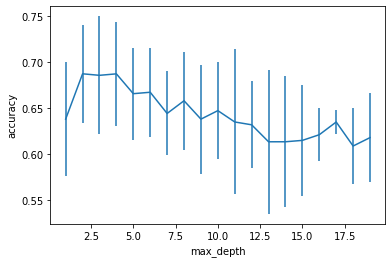

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

## Confusion Matrix

In [64]:
d['pass'].value_counts()

1    328
0    321
Name: pass, dtype: int64

In [65]:
#Defining features and target variable
y = d['pass'] #target variable we want to predict 
X = d.drop(columns = ['pass']) #set of required features, in this case all
#Splitting the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
#Predicting using Logistic Regression for Binary classification 
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train) #fitting the model 
y_pred = LR.predict(X_test) #prediction

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix, without normalization
[[48 24]
 [25 66]]


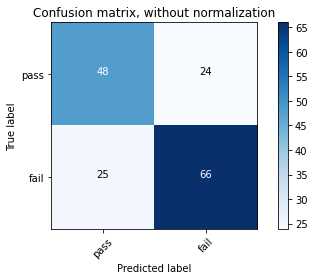

In [67]:
#Evaluation of Model - Confusion Matrix Plot
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['pass','fail'],
                      title='Confusion matrix, without normalization')

In [68]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  48
False Positives:  24
False Negatives:  25
True Positives:  66


# Confusion matrix explanation
True Negatives are more than True Positives.
The number of each False Positives and False Negatives are similar.
True values are more than double of False values. It means this model predicts students' pass or fail not bad.